In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# CCTV 데이터 불러오기
df = pd.read_excel("cctv데이터.xlsx")  # 파일 경로 맞게 조정

# 위도/경도 컬럼명 맞추기
df = df[['WGS84위도', 'WGS84경도']].dropna()

# 서울 중심 좌표로 지도 생성
seoul_center = [37.5665, 126.9780]
m = folium.Map(location=seoul_center, zoom_start=11)

# 마커 클러스터
marker_cluster = MarkerCluster().add_to(m)

# CCTV 마커 추가
for _, row in df.iterrows():
    folium.Marker(location=[row['WGS84위도'], row['WGS84경도']]).add_to(marker_cluster)

# 지도 저장
m.save("seoul_cctv_map.html")

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from collections import defaultdict
from dotenv import load_dotenv

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

def read_and_extract_city(file_path, year, city='서울', id_col_count=3):
    """
    엑셀 파일을 읽어와 3행을 다중 헤더로 사용하고, 
    범죄 항목(첫 id_col_count 열)에 forward-fill을 적용한 후,
    헤더 레벨 0(연도)가 지정한 year이고, 헤더 레벨 1(도시)가 지정한 city인 열만 추출하여 DataFrame 반환.
    """
    df = pd.read_excel(file_path, header=[0, 1, 2])
    df.iloc[:, :id_col_count] = df.iloc[:, :id_col_count].ffill()
    
    id_cols = df.columns[:id_col_count]
    other_cols = df.columns[id_col_count:]
    target_cols = [col for col in other_cols if str(col[0]).strip() == str(year) and col[1] == city]
    
    df_target = df.loc[:, list(id_cols) + target_cols].copy()
    df_target.columns = ['_'.join(map(str, col)).strip() for col in df_target.columns.values]
    
    return df_target

def read_and_extract_district(file_path, year, district, city='서울', id_col_count=3):
    """
    파일을 읽어와 3행 다중 헤더를 사용하고, 
    범죄 항목(첫 id_col_count 열)에 forward-fill을 적용한 후,
    헤더 레벨 0(연도)가 year, 레벨 1(도시)가 city, 레벨 2(구)가 district인 열만 선택하여 
    식별용 열과 함께 반환하는 함수.
    """
    df = pd.read_excel(file_path, header=[0, 1, 2])
    df.iloc[:, :id_col_count] = df.iloc[:, :id_col_count].ffill()
    
    id_cols = df.columns[:id_col_count]
    other_cols = df.columns[id_col_count:]
    
    target_cols = [col for col in other_cols 
                   if str(col[0]).strip() == str(year) 
                   and col[1] == city 
                   and str(col[2]).strip() == district]
    
    df_target = df.loc[:, list(id_cols) + target_cols].copy()
    df_target.columns = ['_'.join(map(str, col)).strip() for col in df_target.columns.values]
    
    return df_target

load_dotenv()

# 환경 변수 불러오기
file2023_path = os.getenv('FILE2023_PATH')
file_path22_21 = os.getenv('FILE_PATH22_21')
file_path19_20 = os.getenv('FILE_PATH19_20')
file_path17_18 = os.getenv('FILE_PATH17_18')
file_image_crime = os.getenv('File_image_crime')

# 서울 전체 데이터 추출 (연도별)
df2023 = read_and_extract_city(file2023_path, year=2023, city='서울')
df2022 = read_and_extract_city(file_path22_21, year=2022, city='서울')
df2021 = read_and_extract_city(file_path22_21, year=2021, city='서울')
df2020 = read_and_extract_city(file_path19_20, year=2020, city='서울')
df2019 = read_and_extract_city(file_path19_20, year=2019, city='서울')
df2018 = read_and_extract_city(file_path17_18, year=2018, city='서울')
df2017 = read_and_extract_city(file_path17_18, year=2017, city='서울')

# 서울 광진구 데이터 추출 (연도별) - 필요 시 사용
df_2023_guangjingu = read_and_extract_district(file2023_path, year=2023, district='광진')
df_2022_guangjingu = read_and_extract_district(file_path22_21, year=2022, district='광진')
df_2021_guangjingu = read_and_extract_district(file_path22_21, year=2021, district='광진')
df_2020_guangjingu = read_and_extract_district(file_path19_20, year=2020, district='광진')
df_2019_guangjingu = read_and_extract_district(file_path19_20, year=2019, district='광진')
df_2018_guangjingu = read_and_extract_district(file_path17_18, year=2018, district='광진')
df_2017_guangjingu = read_and_extract_district(file_path17_18, year=2017, district='광진')

# 사용할 범죄 유형 및 연도 리스트
categories = list(df2023['범죄별(2)_범죄별(2)_범죄별(2)'].unique())
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# 사용자 지정 색상 (요청한 색상 계열)
color_list = [
    "#00008B",  # DarkBlue
    "#0000CD",  # MediumBlue
    "#191970",  # MidnightBlue
    "#1E90FF",  # DodgerBlue
    "#4169E1",  # RoyalBlue
    "#4682B4",  # SteelBlue
    "#5F9EA0",  # CadetBlue
    "#6495ED"   # CornflowerBlue
]
# 연도별 데이터프레임 리스트
year_df = [df2023, df2022, df2021, df2020, df2019, df2018, df2017]

filtered_data = {}

# 데이터 필터링 및 NaN값 처리
for category in categories:
    filtered_data[category] = []
    for df in year_df:
        filtered_df = df[df['범죄별(2)_범죄별(2)_범죄별(2)'] == category]
        filtered_df = filtered_df.drop(columns=['범죄별(2)_범죄별(2)_범죄별(2)'])
        filtered_df = filtered_df.reset_index(drop=True)
        filtered_df = filtered_df.replace("-", 0)
        filtered_data[category].append(filtered_df)

list_total2 = []

# 각 범죄 유형에 대해 연도별 데이터프레임 합산
for i in range(len(year_df)):
    for j in categories:
        list_sum = filtered_data[j][i].iloc[:, 3:].replace("-", 0).astype(int).sum().sum()
        list_total2.append([years[i], j, list_sum])

# 항목별 전체 합계 계산 (파이차트용)
from collections import defaultdict
crime_totals = defaultdict(int)
for _, crime, value in list_total2:
    crime_totals[crime.strip()] += value

labels = list(crime_totals.keys())
values = list(crime_totals.values())
total = sum(values)
percentages = [100 * v / total for v in values]
legend_labels = [f"{label}: {pct:.1f}%" for label, pct in zip(labels, percentages)]

# 데이터프레임 변환 (누적 막대 그래프용)
df_chart = pd.DataFrame(list_total2, columns=['년도', '범죄유형', '건수'])
df_pivot = df_chart.pivot(index='년도', columns='범죄유형', values='건수')




C:\Users\hyunj\AppData\Local\Temp\ipykernel_14576\1936813515.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df = filtered_df.replace("-", 0)
C:\Users\hyunj\AppData\Local\Temp\ipykernel_14576\1936813515.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df = filtered_df.replace("-", 0)
C:\Users\hyunj\AppData\Local\Temp\ipykernel_14576\1936813515.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `resu

In [2]:

df = df_chart

In [3]:
# 2017년 데이터 필터링 및 합계 계산
sum_2017 = df[df['년도'] == 2017]['건수'].sum()
sum_2018 = df[df['년도'] == 2018]['건수'].sum()
sum_2019 = df[df['년도'] == 2019]['건수'].sum()
sum_2020 = df[df['년도'] == 2020]['건수'].sum()
sum_2021 = df[df['년도'] == 2021]['건수'].sum()
sum_2022 = df[df['년도'] == 2022]['건수'].sum()
sum_2023 = df[df['년도'] == 2023]['건수'].sum()

year = [i for i in range(2017,2024)]
sum_year = [sum_2017,sum_2018,sum_2019,sum_2020,sum_2021,sum_2022,sum_2023]

crime_summary_df = pd.DataFrame({
    '년도': year,
    '범죄발생합계': sum_year
})

crime_summary_df

,년도,범죄발생합계
0,2017,194432
1,2018,188273
2,2019,168136
3,2020,199415
4,2021,208485
5,2022,203163
6,2023,204612


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import warnings

warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

load_dotenv()

# 환경 변수 불러오기
file2023_path = os.getenv('FILE2023_PATH')
file_path22_21 = os.getenv('FILE_PATH22_21')
file_path19_20 = os.getenv('FILE_PATH19_20')
file_path17_18 = os.getenv('FILE_PATH17_18')

file = r'E:\Traffic-Safety\위치 데이터\cctv데이터.xlsx'
# 데이터 불러오기
cctv = pd.read_excel(file)
crime1 = pd.read_excel(file_path17_18, skiprows=1, header=[0, 1], engine='openpyxl')
crime2 = pd.read_excel(file_path19_20, skiprows=1, header=[0, 1], engine='openpyxl')
crime3 = pd.read_excel(file_path22_21, skiprows=1, header=[0, 1], engine='openpyxl')
crime4 = pd.read_excel(file2023_path, skiprows=1, header=[0, 1], engine='openpyxl')

In [5]:
# CCTV 데이터에서 자치구 추출
df= cctv['설치연월'].value_counts().reset_index()
df

,설치연월,count
0,2020-12,1027
1,2022-12,1008
2,2018-12,992
3,2021-12,981
4,2016-12,972
...,...,...
218,2006-07,1
219,2012-07,1
220,2014-03,1
221,2006-02,1


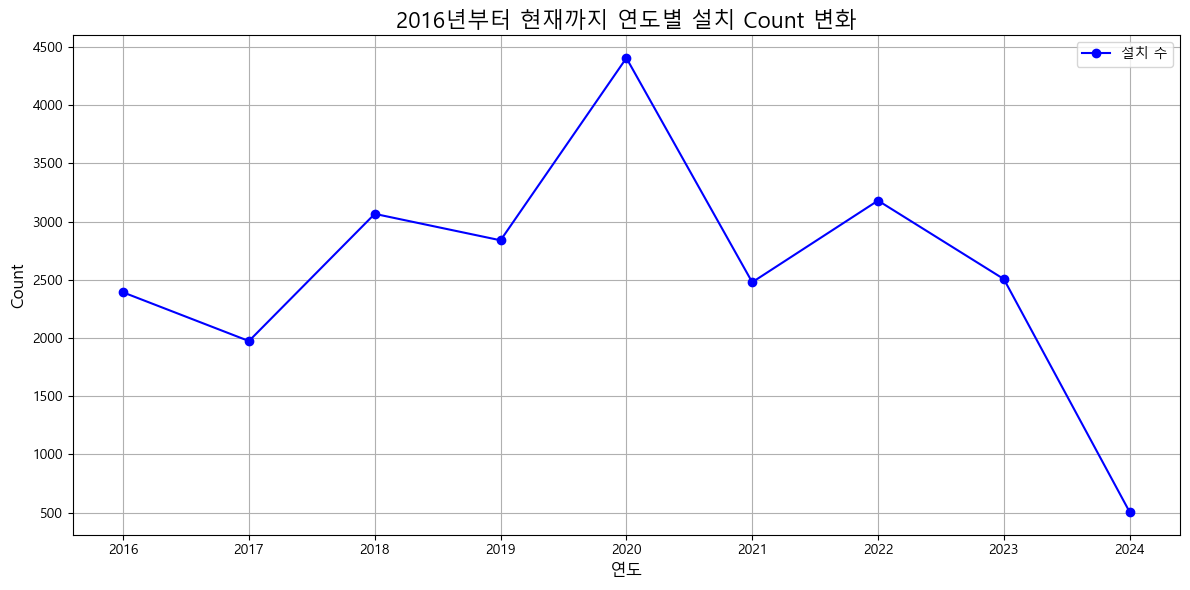

In [6]:

# 설치연월을 datetime 형식으로 변환
df['설치연월'] = pd.to_datetime(df['설치연월'], format='%Y-%m')

# 연도 추출
df['연도'] = df['설치연월'].dt.year

# 2016년부터 현재(2025년)까지 필터링
filtered_df = df[df['연도'] >= 2016]

# 연도별 집계 (count 합계)
df_yearly = filtered_df.groupby('연도')['count'].sum().reset_index()

# 라인차트 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_yearly['연도'], df_yearly['count'], marker='o', linestyle='-', color='blue', label='설치 수')

# 그래프 꾸미기
plt.title('2016년부터 현재까지 연도별 설치 Count 변화', fontsize=16)
plt.xlabel('연도', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(df_yearly['연도'])
plt.legend()
plt.grid()

# 출력
plt.tight_layout()
plt.show()

In [7]:
df_yearly

,연도,count
0,2016,2392
1,2017,1974
2,2018,3066
3,2019,2839
4,2020,4404
5,2021,2479
6,2022,3180
7,2023,2506
8,2024,506


In [8]:
# 범죄 데이터 통합
crime_all = pd.concat([crime1, crime2, crime3, crime4])

df_filtered = crime1[crime1[('범죄별(1)', '범죄별(1)')] == '형법범']

seoul = [i for i in df_filtered if "서울" in i[0]]


In [9]:
# 열들 추출
crime_data = df_filtered[seoul].copy()  # 범죄_서울 구 추출
gu_list = [i[1] + "구" for i in df_filtered if "서울" in i[0]]  # 서울 구만 추출
monthly_crime_totals = crime_data.values.flatten().tolist()  # 범죄 구 별 범죄 합

crime_summary_df = pd.DataFrame({
    '자치구': gu_list,
    '범죄발생합계': monthly_crime_totals
})

# 자치구 정제
crime_summary_df['자치구'] = crime_summary_df['자치구'].str.replace(r'\.1구$', '구', regex=True)
crime_summary_df['자치구'] = crime_summary_df['자치구'].str.replace(r'구구$', '구', regex=True)

# 자치구별로 범죄발생합계 집계
crime_group = crime_summary_df.groupby('자치구', as_index=False)['범죄발생합계'].sum()

print(crime_group)


     자치구  범죄발생합계
0    강남구    6166
1    강동구    3164
2    강북구    2130
3    강서구    3616
4    관악구    4305
5    광진구    3945
6    구로구    3456
7    금천구    2008
8    노원구    2954
9    도봉구    1419
10  동대문구    3007
11   동작구    2383
12   마포구    4120
13  서대문구    2290
14   서초구    3687
15   성동구    2072
16   성북구    2509
17   송파구    4635
18   양천구    2975
19  영등포구    4598
20   용산구    2518
21   은평구    2663
22   종로구    3136
23    중구    3697
24   중랑구    3063


In [10]:
# CCTV 데이터에서 자치구 추출
cctv['자치구'] = cctv['관리기관명'].str.extract(r'(\S+구)')
cctv_by_gu = cctv['자치구'].value_counts().reset_index()
cctv_by_gu.columns = ['자치구', 'CCTV_수']
cctv_by_gu

,자치구,CCTV_수
0,서초구,5428
1,양천구,4795
2,영등포구,4697
3,송파구,4669
4,강북구,3584
5,노원구,3111
6,강남구,2578
7,구로구,2060
8,관악구,2040
9,용산구,1930


In [11]:
merged_df = pd.merge(cctv_by_gu, crime_group, on='자치구', how='inner')

# 5. 범죄 대비 CCTV 비율 계산 (비율이 높을수록 범죄 발생 건수에 비해 CCTV가 부족하다고 해석 가능)
merged_df['범죄/CCTV_ratio'] = merged_df['범죄발생합계'] / merged_df['CCTV_수']

# 비율이 높은 순으로 정렬
merged_df = merged_df.sort_values('범죄/CCTV_ratio', ascending=False)

merged_df

,자치구,CCTV_수,범죄발생합계,범죄/CCTV_ratio
19,중구,1078,3697,3.429499
21,종로구,935,3136,3.354011
17,광진구,1185,3945,3.329114
15,마포구,1328,4120,3.102410
23,동작구,890,2383,2.677528
18,동대문구,1156,3007,2.601211
6,강남구,2578,6166,2.391777
14,중랑구,1357,3063,2.257185
13,강동구,1461,3164,2.165640
20,서대문구,1061,2290,2.158341


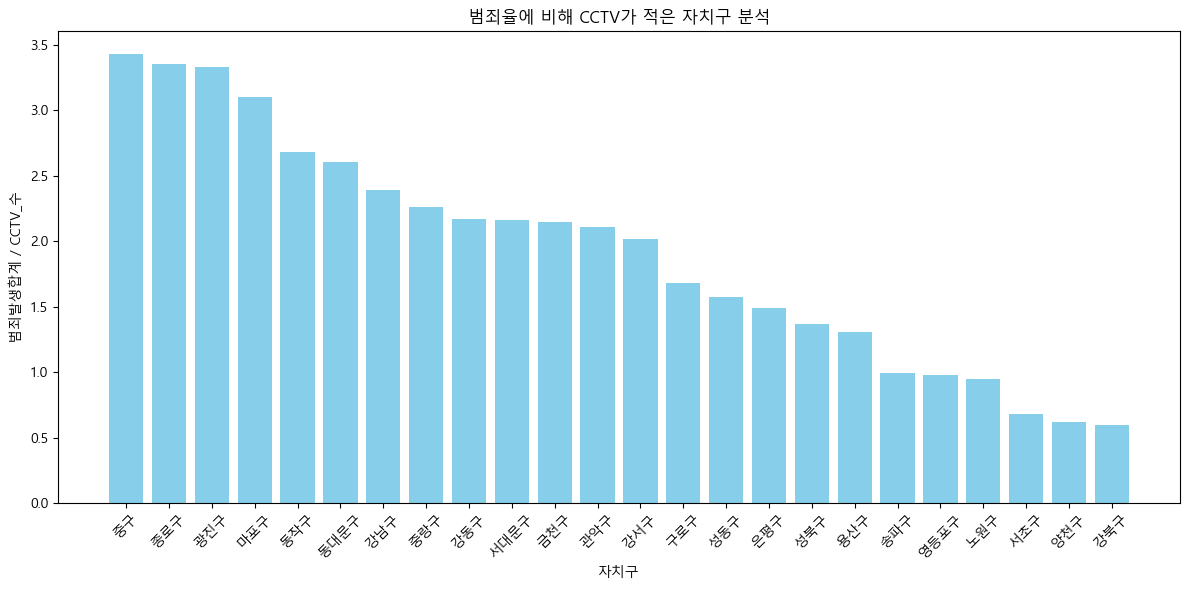

In [12]:
# 6. 시각화: 자치구별 범죄/CCTV 비율 바 차트
plt.figure(figsize=(12,6))
plt.bar(merged_df['자치구'], merged_df['범죄/CCTV_ratio'], color='skyblue')
plt.xlabel('자치구')
plt.ylabel('범죄발생합계 / CCTV_수')
plt.title('범죄율에 비해 CCTV가 적은 자치구 분석')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

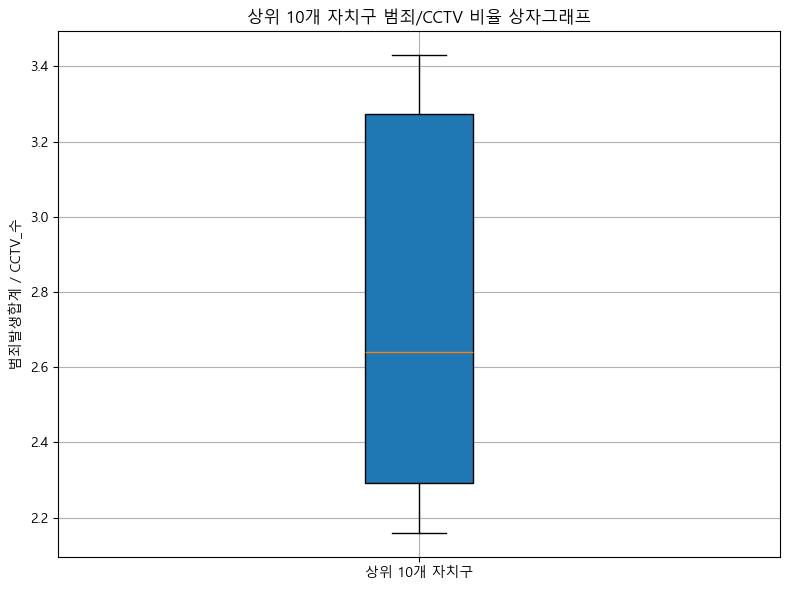

In [13]:
top10 = merged_df.sort_values('범죄/CCTV_ratio', ascending=False).head(10)

# 7. 상위 10개 자치구의 비율 데이터를 상자그래프로 시각화
plt.figure(figsize=(8,6))
plt.boxplot(top10['범죄/CCTV_ratio'], patch_artist=True)
plt.ylabel("범죄발생합계 / CCTV_수")
plt.title("상위 10개 자치구 범죄/CCTV 비율 상자그래프")
plt.xticks([1], ["상위 10개 자치구"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
overall_whislo = merged_df['범죄/CCTV_ratio'].min()
overall_q1 = np.percentile(merged_df['범죄/CCTV_ratio'], 25)
overall_q3 = np.percentile(merged_df['범죄/CCTV_ratio'], 75)
overall_whishi = merged_df['범죄/CCTV_ratio'].max()

# 6. 자치구별 평균 비율을 구한 후 상위 10개 자치구(평균 비율 기준) 선정
mean_by_district = merged_df.groupby('자치구')['범죄/CCTV_ratio'].mean()
top10 = mean_by_district.sort_values(ascending=False).head(10)
top10_districts = top10.index.tolist()

# 7. 각 자치구별로 개별 중앙값(자치구별 중앙값)만 구하고, 상자(whislo, q1, q3, whishi)는 전체 데이터 기준 사용
box_items = []
for district in top10_districts:
    group_data = merged_df.loc[merged_df['자치구'] == district, '범죄/CCTV_ratio'].values
    district_median = np.median(group_data) if len(group_data) > 0 else np.median(merged_df['범죄/CCTV_ratio'].values)
    box_items.append({
        'label': district,
        'whislo': overall_whislo,  # 전체 최소값
        'q1': overall_q1,          # 전체 1사분위
        'med': district_median,    # 자치구별 중앙값
        'q3': overall_q3,          # 전체 3사분위
        'whishi': overall_whishi,  # 전체 최대값
        'fliers': []               # 이상치 없음 (또는 별도 처리)
    })


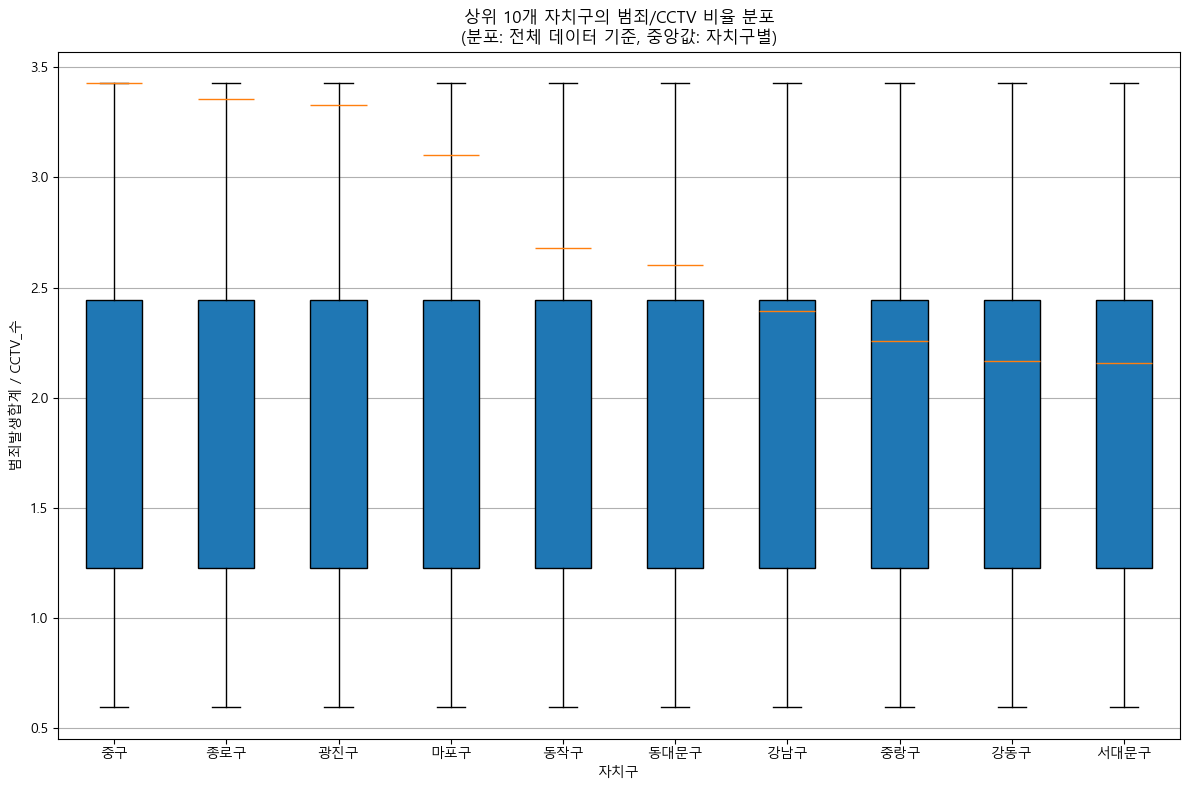

In [15]:
# 8. Axes 객체에서 bxp()를 사용하여 상자그래프 그리기
fig, ax = plt.subplots(figsize=(12, 8))
ax.bxp(box_items, showfliers=True, patch_artist=True)
ax.set_xlabel("자치구")
ax.set_ylabel("범죄발생합계 / CCTV_수")
ax.set_title("상위 10개 자치구의 범죄/CCTV 비율 분포\n(분포: 전체 데이터 기준, 중앙값: 자치구별)")
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

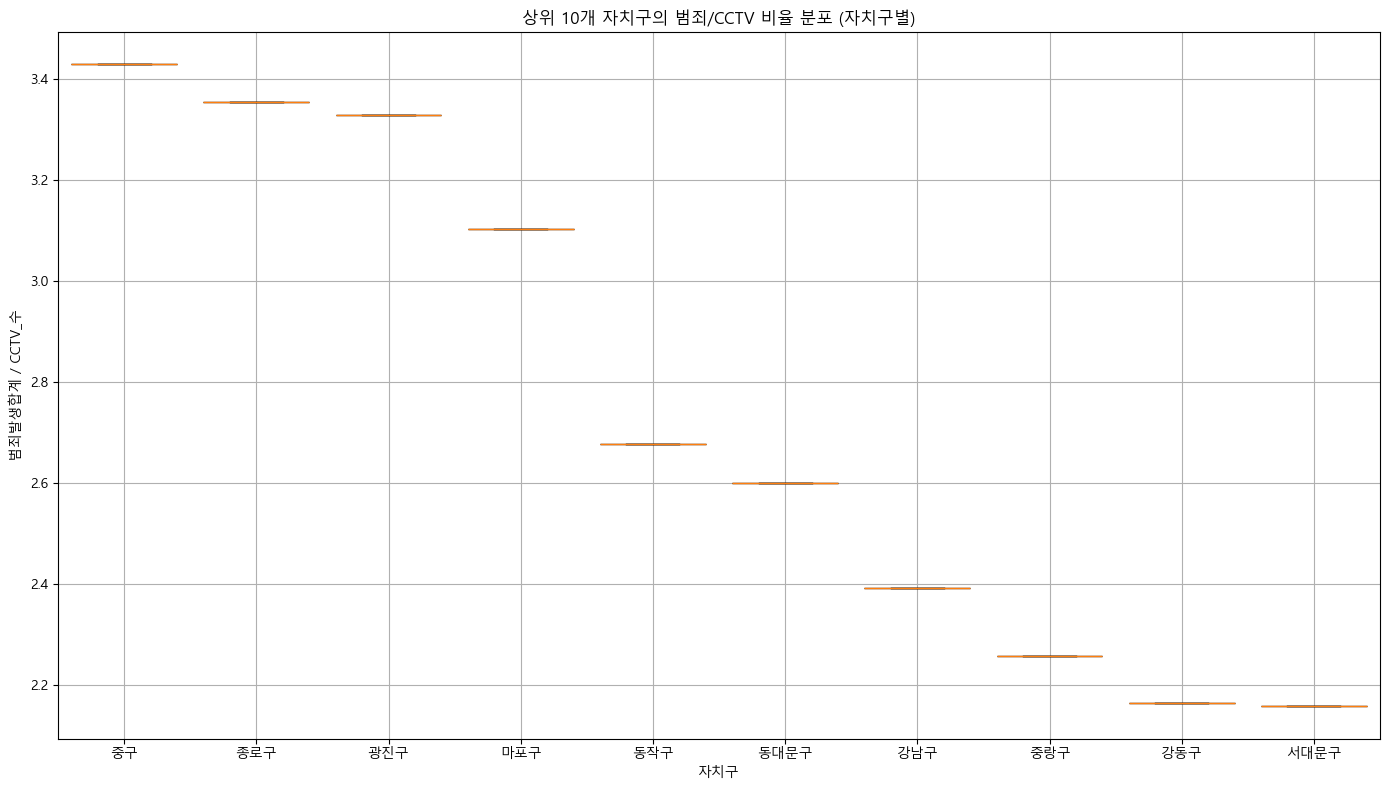

In [16]:
# 5. 자치구별 평균 비율 계산 후, 비율이 높은 순으로 상위 10개 자치구 선정
mean_ratios = merged_df.groupby('자치구')['범죄/CCTV_ratio'].mean()
mean_ratios = mean_ratios.sort_values(ascending=False)
top10_districts = mean_ratios.head(10).index.tolist()

# 6. 상위 10개 자치구에 해당하는 데이터만 필터링
filtered_df = merged_df[merged_df['자치구'].isin(top10_districts)]

# 7. 각 자치구별 "범죄/CCTV_ratio" 분포 데이터를 리스트로 준비
box_data = [filtered_df[filtered_df['자치구'] == district]['범죄/CCTV_ratio'] for district in top10_districts]

# 8. 자치구별 상자그래프 그리기 (그림 크기와 상자 너비 조정)
plt.figure(figsize=(14,8))
plt.boxplot(box_data, patch_artist=True, widths=0.8)
plt.xticks(range(1, len(top10_districts)+1), top10_districts)
plt.xlabel("자치구")
plt.ylabel("범죄발생합계 / CCTV_수")
plt.title("상위 10개 자치구의 범죄/CCTV 비율 분포 (자치구별)")
plt.grid(True)
plt.tight_layout()
plt.show()

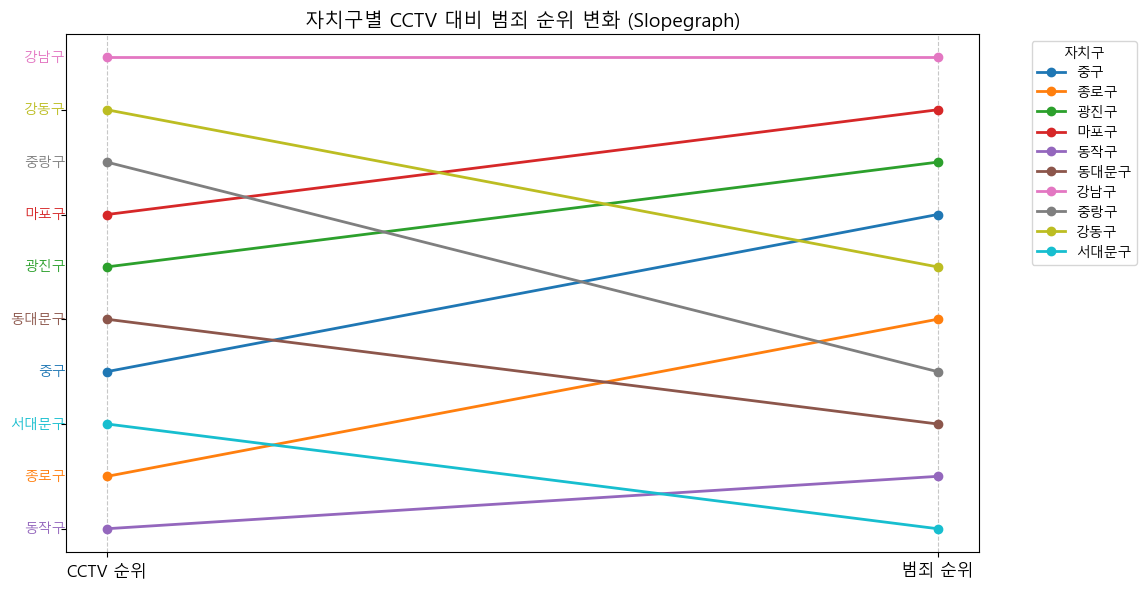

In [17]:
import matplotlib.pyplot as plt

slope_df = pd.DataFrame({
    "자치구": top10_districts,
    "CCTV_순위": merged_df.set_index("자치구").loc[top10_districts]['CCTV_수'].rank(ascending=False).values,
    "범죄_순위": merged_df.groupby("자치구")["범죄발생합계"].mean().loc[top10_districts].rank(ascending=False).values
})

plt.figure(figsize=(10, 6))

# 색상 설정 (상위 10개 자치구이므로 tab10 컬러맵 사용)
colors = plt.cm.tab10(range(len(slope_df)))

# 각 자치구별로 선과 텍스트 그리기 (각 선은 서로 다른 색상)
for i in range(len(slope_df)):
    color = colors[i]
    # 선 그리기
    plt.plot([0, 1],
             [slope_df["CCTV_순위"].iloc[i], slope_df["범죄_순위"].iloc[i]],
             marker='o', color=color, linewidth=2, label=slope_df["자치구"].iloc[i])
    # 왼쪽에 자치구 이름 텍스트 표시
    plt.text(-0.05, slope_df["CCTV_순위"].iloc[i], slope_df["자치구"].iloc[i],
             ha='right', va='center', color=color)

# x축 레이블 설정
plt.xticks([0, 1], ["CCTV 순위", "범죄 순위"], fontsize=12)
plt.title("자치구별 CCTV 대비 범죄 순위 변화 (Slopegraph)", fontsize=14)

# y축 텍스트 숨기기
plt.gca().set_yticklabels([])

# y축 순위를 낮은 숫자가 상단에 오도록 뒤집기
plt.gca().invert_yaxis()

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# 범례 추가 (범례는 차트 외부 우측에 배치)
plt.legend(title="자치구", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
plt.show()


In [20]:
merged_df.head(1)
df = merged_df

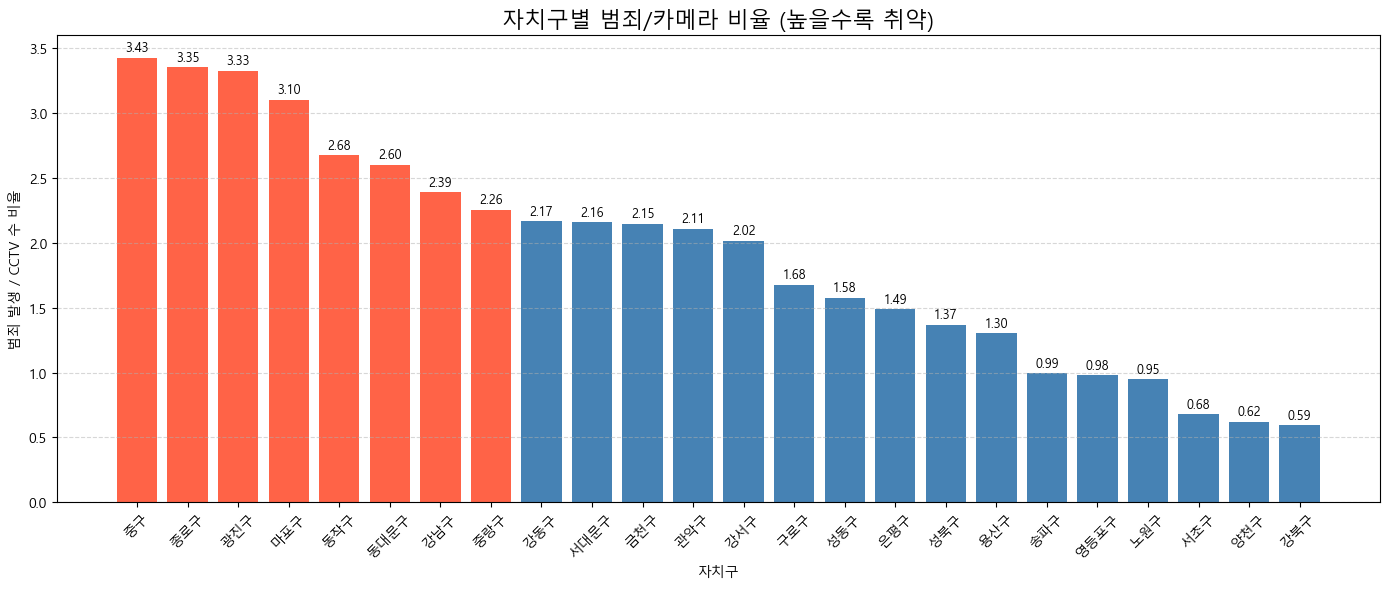

In [21]:
# ✅ 비율 계산
df['범죄/CCTV_ratio'] = df['범죄발생합계'] / df['CCTV_수']

# ✅ 높은 순으로 정렬 (범죄 많고 CCTV 적은 지역)
df_sorted = df.sort_values(by='범죄/CCTV_ratio', ascending=False).reset_index(drop=True)

# ✅ 상위 8개를 우선 설치 권장 구역으로 간주
top_8 = df_sorted.head(8)

# ✅ 시각화: 전체 막대그래프 + 취약지역 강조
plt.figure(figsize=(14, 6))
colors = ['tomato' if gu in top_8['자치구'].values else 'steelblue' for gu in df_sorted['자치구']]

bars = plt.bar(df_sorted['자치구'], df_sorted['범죄/CCTV_ratio'], color=colors)

# 제목, 레이블
plt.title('자치구별 범죄/카메라 비율 (높을수록 취약)', fontsize=16)
plt.xlabel('자치구')
plt.ylabel('범죄 발생 / CCTV 수 비율')
plt.xticks(rotation=45)

# 값 표시
for idx, bar in enumerate(bars):
    ratio = df_sorted.iloc[idx]['범죄/CCTV_ratio']
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{ratio:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
